# Машинное обучение, ФКН ВШЭ
## Практическое задание 8

### Общая информация

Дата выдачи: 14.03.2019

Мягкий дедлайн: 24.03.2019 05:59 MSK

Жёсткий дедлайн: 28.03.2019 05:59 MSK

### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость», которая будет объявлена после жёсткого дедлайна. Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце Вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

В финальной версии ноутбука, которая отправляется для сдачи задания, должны быть быть выполнены следующие условия:
* все ячейки выполнены для представленной в ноутбуке версии кода;
* результаты выполнения ячеек отображены и согласованы с кодом;
* при повторном запуске ячеек результаты должны воспроизводиться с точностью до случайности.


### Формат сдачи

Задания сдаются через систему anytask. Посылка должна содержать:

* Ноутбук homework-practice-08-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

## Кластеризация

Задача [кластеризации](https://en.wikipedia.org/wiki/Cluster_analysis) данных является одним из примеров задач обучения "без учителя". Она заключается в разбиении множества объектов на заданное число кластеров, при этом предполагается, что внутри одного кластера будут находиться похожие между собой объекты. Одним из примеров методов кластеризации является алгоритм [KMeans](https://en.wikipedia.org/wiki/K-means_clustering).

### Выбор числа кластеров

Для некоторых алгоритмов кластеризации число кластеров является гиперпараметром (например, в случае KMeans). Поэтому для выбора количества кластеров может быть использован следующий подход: при фиксированной метрике качества для разного числа кластеров обучают алгоритм и выбирают то значение гиперпараметра, начиная с которого качество "стабилизируется".

### Метрики качества

Оценивание качества построенной кластеризации — не всегда тривиальная задача, поскольку следует учитывать ряд фактов:
 - объекты одного класса должны быть более похожими, чем объекты других кластеров, относительно некоторой заданной метрики похожести
 - метрика не должна учитывать истинные значения меток объектов, попавших в кластер (в случае, если истинные метки известны)

При выполнении задания для оценки качества получившейся кластеризации воспользуемся следующими метриками:
 - [Homogeneity и Completeness](http://scikit-learn.org/stable/modules/clustering.html#homogeneity-completeness-and-v-measure) 
 - [Adjusted Rand index](http://scikit-learn.org/stable/modules/clustering.html#adjusted-rand-index) 
 - [Silhouette Coefficient](http://scikit-learn.org/stable/modules/clustering.html#silhouette-coefficient)

Загрузите набор данных [digits](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html). Перед применением алгоритмов не забудьте перемешать изображения в случайном порядке.

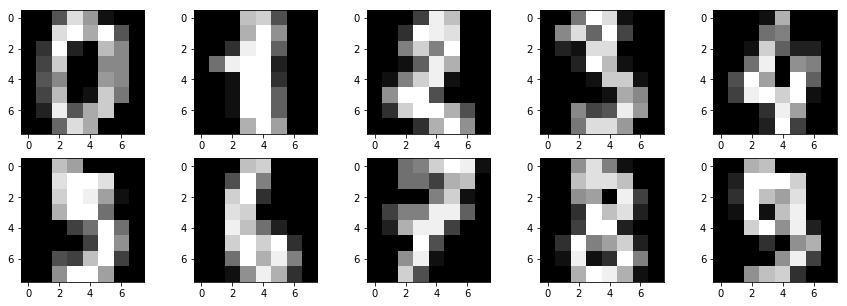

In [127]:
import sklearn
import sklearn.datasets
import sklearn.utils
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np


IMG_SIZE = 8
IMG_SHAPE = (IMG_SIZE, IMG_SIZE)
(x_data, y_data) = sklearn.datasets.load_digits(return_X_y=True)

def show_images(images, n_first_images=10):
    if len(images.shape) == 2:
        images = images.reshape((-1,) + IMG_SHAPE)
    plt.figure(figsize=(15, 5))
    for i in range(n_first_images):
        plt.subplot((n_first_images - 1) // 5 + 1, 5, i + 1)
        plt.imshow(images[i], cmap='gray')

show_ten_images(x_data[:10])
    
x_data, y_data = sklearn.utils.shuffle(x_data, y_data)

**1.** Кластеризуйте изображения при помощи алгоритма [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html), подобрав число кластеров для каждой из метрик, указанных выше. Рассмотрите различные способы выбора начального приближения (параметр *init*). Оцените качество получившейся кластеризации, используя все описанные выше метрики. Визуализируйте изображения, соответствующие центроидам лучшей кластеризации.

In [114]:
from sklearn.cluster import KMeans
from sklearn.metrics import homogeneity_score, completeness_score, adjusted_rand_score, silhouette_score, v_measure_score
from tqdm import tqdm_notebook as tqdm

class Metrics:
    def __init__(self, score_func, on_labels=True):
        self._score_func = score_func
        self._on_labels = on_labels
        
    def is_on_labels(self):
        return self._on_labels
    
    def score_on_labels(self, y_true, y_pred):
        assert(self.is_on_labels())
        return self._score_func(y_true, y_pred)
        
    def score_on_itself(self, x_data, y_pred):
        assert(not(self.is_on_labels()))
        return self._score_func(x_data, y_pred)
    
    def get_name(self):
        return self._score_func.__name__
        
def get_best_clusters(x_data, y_data, metricses, cluster_max=20, init_params='k-means++'):
    best_cluster = np.array([1]*len(metricses))
    best_score = np.zeros(shape=(len(metricses)), dtype=np.float)
    best_estimators = []
    for i in tqdm(range(2, cluster_max + 1)):
        km = KMeans(n_clusters=i, init=init_params)
        km.fit(x_data, y_data)
        y_pred = km.predict(x_data)

        cur_score = np.zeros_like(best_score)
        for j, metrics in enumerate(metricses):
            if metrics.is_on_labels():
                score = metrics.score_on_labels(y_data, y_pred)
            else:
                score = metrics.score_on_itself(x_data, y_pred)
            cur_score[j] = score
            best_estimators.append(km)
        ind = cur_score > best_score
        best_score[ind] = cur_score[ind]
        best_cluster[ind] = i
    return best_cluster, best_score

In [119]:
metr = [Metrics(v_measure_score), Metrics(adjusted_rand_score), Metrics(silhouette_score, False)]
def print_log(clusters, scores):
    for i, metrics in enumerate(metr):
        print(metrics.get_name(), 'with score', round(scores[i], 3), 'on', clusters[i], 'clusters')
    print()

In [123]:
print_log(*get_best_clusters(x_data, y_data, metr, cluster_max=30))
print_log(*get_best_clusters(x_data, y_data, metr, cluster_max=30, init_params='random'))

v_measure_score with score 0.788 on 15 clusters
adjusted_rand_score with score 0.739 on 11 clusters
silhouette_score with score 0.189 on 9 clusters


v_measure_score with score 0.793 on 12 clusters
adjusted_rand_score with score 0.749 on 12 clusters
silhouette_score with score 0.189 on 9 clusters


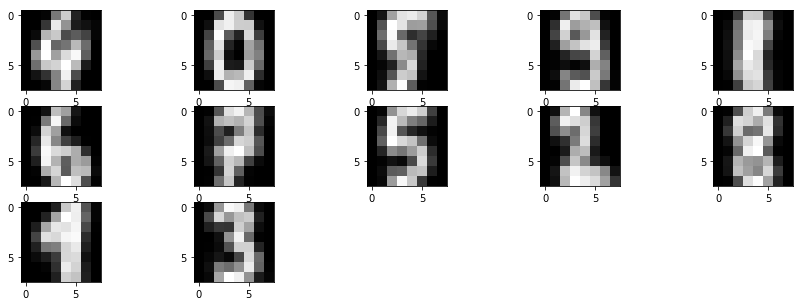

In [128]:
km = KMeans(n_clusters=12, init='random')
km.fit(x_data, y_data)
images = km.cluster_centers_
show_images(images, len(images))

Не всегда бывает удобно работать с полной матрицей объект—признак — например, для визуализации подходят лишь выборки размерности не больше трёх. На лекциях был рассмотрен метод уменьшения размерности *PCA*. В документации sklearn есть [сравнение](http://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html#example-manifold-plot-lle-digits-py) различных способов понижения размерности для проекции на плоскость. На изображениях видно, что некоторые преобразования дают неплохую визуализацию, где одинаковые цифры расположены близко друг к другу. Посмотрим, поможет ли это на практике.
 
**2.** Примените преобразования [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) и [t-SNE](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) (для числа компонент 2 и 10), проведите кластеризацию в новых признаковых пространствах и сравните результаты с предыдущими. Нашелся ли метод кластеризации, превосходящий другие по всем метрикам? Являются ли все три метрики согласованными? Можете ли вы объяснить, почему так произошло?

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

**3.** Визуализируйте несколько изображений, которые во всех случаях были отнесены к неправильному кластеру (объект назовем ошибочно отнесенным, если он имеет иную метку класса, нежели большая часть объектов в кластере). Можете ли вы пояснить, почему так произошло?

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

## Разделение изображения на семантические компоненты

![RedPanda](http://imgur.com/6Aa52Lm.png)

Алгоритмы кластеризации могут применяться в самых разных целях. Например, в анализе изображений есть задача разделения изображения на семантические компоненты, которую можно решать в том числе с помощью алгоритмов кластеризации. 

Выберите несколько (не менее 5) своих любимых изображений, для которых вы будете применять методы из следующих пунктов (за выбор изображений могут быть начислены бонусные баллы!).

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

**4.** Для каждого изображения, используя кластеризацию KMeans, выделите компоненты, охарактеризовав каждый пиксель вектором признаков $\psi_i = [\lambda x_i, \lambda y_i, r_i, g_i, b_i]$, где 
$x_i$ и $y_i$ — координаты пикселя, $r_i, g_i, b_i$ — его цвет, $\lambda$ — параметр, выражающий важность пространственной связности перед цветовой похожестью.

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

**5.** Попробуйте выделить сегменты при помощи [спектральной кластеризации](http://scikit-learn.org/stable/modules/clustering.html#spectral-clustering). Обратите внимание на [пример в sklearn](http://scikit-learn.org/0.16/auto_examples/cluster/plot_lena_segmentation.html). Для ускорения работы алгоритма рекомендуется привести изображение к серому цвету. При необходимости можно сжать изображения (в пределах разумного).

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

**6.** Визуализируйте результаты сегментации (аналогично рисунку выше) для обоих методов. [Пример кода для визуализации](http://scikit-learn.org/0.16/auto_examples/cluster/plot_lena_segmentation.html).

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

**7.** Поэкспериментируйте с параметрами алгоритмов и параметром $\lambda$ в признаках. Сравните два подхода и сегментации, к которым они приводят.
Для всех ли изображений в результате сегментации хорошо видны контуры объектов?

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Измерять качество сегментации в этом пункте не нужно, в результате ожидаются только картинки и выводы.

### Рекомендации к выполнению
Для работы с изображениями удобно использовать библиотеку [Scikit-Image](http://scikit-image.org). 
Установите [PIL](http://www.pythonware.com/products/pil/) для возможности чтения формата JPG.

Пример чтения изображения в матрицу:

    from skimage.io import imread
    I = imread('http://www.birdsgallery.net/gallery/parrots/parrots_4.jpg')

    figure(figsize=(15, 5))
        for i in xrange(3):
        subplot(1, 3, i)
        imshow(I[:,:,i])